# Chapter 5: Matching and Subclassification
## Causal Inference: The Mixtape → CausalPy

**Mixtape chapter**: [Matching and Subclassification](https://mixtape.scunning.com/05-matching_and_subclassification)

**CausalPy method**: `InversePropensityWeighting`

---

### Overview

Matching and related methods aim to create comparable treatment and control groups by balancing observed covariates. This chapter covers several approaches:

1. **Simple difference in outcomes** (Titanic example)
2. **Experimental benchmark** (NSW randomized experiment)
3. **Inverse Propensity Weighting** (CausalPy's approach)

### What we'll cover

1. Conceptual introduction with the Titanic example
2. Experimental ATE as a benchmark using NSW data
3. IPW estimation using CausalPy with the LaLonde observational data
4. Balance diagnostics and propensity score overlap

### CausalPy Support

CausalPy provides `InversePropensityWeighting` for propensity score-based estimation. Other matching methods (nearest neighbor, subclassification, coarsened exact matching) are not yet supported.

### Mixtape files implemented

| File | Description | Status |
|------|-------------|--------|
| `titanic.py` | Simple difference in outcomes | ✅ (conceptual) |
| `nsw_experimental.py` | NSW experimental benchmark | ✅ |
| `nsw_pscore.py` | Propensity score estimation | ✅ |
| `ipw.py` | Inverse propensity weighting | ✅ |
| `teffects_ipw.py` | Treatment effects via IPW | ✅ |
| `titanic_subclassification.py` | Subclassification | ⏭️ (no CausalPy) |
| `training_example.py` | Training program example | ⏭️ (no CausalPy) |
| `training_bias_reduction.py` | Bias reduction via matching | ⏭️ (no CausalPy) |
| `teffects_nn.py` | Nearest neighbor matching | ⏭️ (missing) |
| `cem.py` | Coarsened exact matching | ⏭️ (missing) |


## Setup


In [1]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import causalpy as cp

# Add the src directory to path for our data utilities
import sys

sys.path.insert(0, "../src")
from mixtape_causalpy import load_nsw, load_cps, load_mixtape_data

%matplotlib inline


---

## Example 1: Simple Difference in Outcomes (Titanic)

Before diving into propensity scores, let's illustrate the fundamental problem with a simple example from the Titanic disaster.

**Question**: Did being in first class improve survival?

A naive comparison of survival rates between first and other classes gives us the **simple difference in outcomes (SDO)**. But this comparison may be confounded by other factors (e.g., cabin location, access to lifeboats).


In [2]:
# Load Titanic data
titanic = load_mixtape_data("titanic.dta")
print(f"Dataset shape: {titanic.shape}")
titanic.head()


Dataset shape: (2201, 4)


,class,age,sex,survived
0,1st class,adults,man,yes
1,1st class,adults,man,yes
2,1st class,adults,man,yes
3,1st class,adults,man,yes
4,1st class,adults,man,yes


In [3]:
# Create binary variables (as in titanic.py)
titanic["first_class"] = (titanic["class"] == "1st class").astype(int)
titanic["survived_d"] = (titanic["survived"] == "yes").astype(int)

# Simple difference in outcomes
ey1 = titanic.loc[titanic["first_class"] == 1, "survived_d"].mean()
ey0 = titanic.loc[titanic["first_class"] == 0, "survived_d"].mean()
sdo = ey1 - ey0

print(f"Survival rate (1st class): {ey1:.1%}")
print(f"Survival rate (other):     {ey0:.1%}")
print(f"\nSimple Difference in Outcomes: {sdo:.1%}")
print("\nThis is NOT necessarily the causal effect - it may be confounded!")


Survival rate (1st class): 62.5%
Survival rate (other):     27.1%

Simple Difference in Outcomes: 35.4%

This is NOT necessarily the causal effect - it may be confounded!


---

## Example 2: NSW Experimental Benchmark

The **National Supported Work (NSW)** demonstration was a randomized job training program in the 1970s. Because treatment was randomly assigned, the simple difference in outcomes is an unbiased estimate of the Average Treatment Effect (ATE).

This experimental estimate serves as a **benchmark** for evaluating observational methods. LaLonde (1986) famously showed that many observational estimators failed to recover this experimental benchmark when using non-experimental control groups.

**Outcome**: Real earnings in 1978 (`re78`)


In [4]:
# Load NSW experimental data
nsw = load_nsw()
print(f"NSW experimental data shape: {nsw.shape}")
print(f"\nTreatment distribution:")
print(nsw["treat"].value_counts())


NSW experimental data shape: (445, 11)

Treatment distribution:
treat
0.0    260
1.0    185
Name: count, dtype: int64


In [5]:
# Key variables
print("Key variables:")
print(
    nsw[
        [
            "treat",
            "age",
            "educ",
            "black",
            "hisp",
            "marr",
            "nodegree",
            "re74",
            "re75",
            "re78",
        ]
    ].describe()
)


Key variables:
            treat         age        educ       black       hisp        marr  \
count  445.000000  445.000000  445.000000  445.000000  445.00000  445.000000   
mean     0.415730   25.370787   10.195505    0.833708    0.08764    0.168539   
std      0.493402    7.100282    1.792119    0.372762    0.28309    0.374766   
min      0.000000   17.000000    3.000000    0.000000    0.00000    0.000000   
25%      0.000000   20.000000    9.000000    1.000000    0.00000    0.000000   
50%      0.000000   24.000000   10.000000    1.000000    0.00000    0.000000   
75%      1.000000   28.000000   11.000000    1.000000    0.00000    0.000000   
max      1.000000   55.000000   16.000000    1.000000    1.00000    1.000000   

         nodegree          re74          re75          re78  
count  445.000000    445.000000    445.000000    445.000000  
mean     0.782022   2102.265381   1377.138306   5300.764160  
std      0.413337   5363.582520   3150.960693   6631.491699  
min      0.00000

In [6]:
# Calculate experimental ATE (as in nsw_experimental.py)
mean_treated = nsw[nsw["treat"] == 1]["re78"].mean()
mean_control = nsw[nsw["treat"] == 0]["re78"].mean()
experimental_ate = mean_treated - mean_control

print(f"Mean earnings (treated):  ${mean_treated:,.2f}")
print(f"Mean earnings (control):  ${mean_control:,.2f}")
print(f"\n*** Experimental ATE: ${experimental_ate:,.2f} ***")
print("\nThis is our benchmark - observational methods should try to recover this.")


Mean earnings (treated):  $6,349.14
Mean earnings (control):  $4,554.80

*** Experimental ATE: $1,794.34 ***

This is our benchmark - observational methods should try to recover this.


---

## Example 3: Inverse Propensity Weighting with CausalPy

Now we'll use CausalPy's `InversePropensityWeighting` to estimate the treatment effect using an **observational control group** (CPS data) instead of the experimental control group.

### The Challenge

When we replace the experimental control group with CPS controls, the simple difference in outcomes will be heavily biased because the CPS sample differs systematically from NSW participants (in age, education, earnings history, etc.).

### The Solution

Inverse Propensity Weighting (IPW) reweights observations to create a "pseudo-population" where treatment assignment is independent of observed covariates.


In [7]:
# Load CPS control data
cps = load_cps()
print(f"CPS data shape: {cps.shape}")


CPS data shape: (15992, 11)


In [8]:
# Combine NSW with CPS controls (as in ipw.py)
# The Mixtape uses the FULL NSW data (both treated and control from the experiment)
# combined with CPS controls, then uses treat indicator to distinguish groups
combined = pd.concat([cps, nsw], ignore_index=True)

# Create unemployment indicators (as in original code)
combined["u74"] = (combined["re74"] == 0).astype(int)
combined["u75"] = (combined["re75"] == 0).astype(int)

print(f"Combined dataset shape: {combined.shape}")
print(f"\nTreatment distribution:")
print(combined["treat"].value_counts())


Combined dataset shape: (16437, 13)

Treatment distribution:
treat
0.0    16252
1.0      185
Name: count, dtype: int64


In [9]:
# Show the bias without adjustment
naive_mean_treated = combined[combined["treat"] == 1]["re78"].mean()
naive_mean_control = combined[combined["treat"] == 0]["re78"].mean()
naive_diff = naive_mean_treated - naive_mean_control

print("Without any adjustment (naive comparison):")
print(f"Mean earnings (NSW treated): ${naive_mean_treated:,.2f}")
print(f"Mean earnings (CPS control): ${naive_mean_control:,.2f}")
print(f"Naive difference: ${naive_diff:,.2f}")
print(f"\nExperimental benchmark: ${experimental_ate:,.2f}")
print(f"Bias: ${naive_diff - experimental_ate:,.2f} (way off!)")


Without any adjustment (naive comparison):
Mean earnings (NSW treated): $6,349.14
Mean earnings (CPS control): $14,682.01
Naive difference: $-8,332.87

Experimental benchmark: $1,794.34
Bias: $-10,127.21 (way off!)


### Visualize Covariate Imbalance

Before applying IPW, let's see how different the treated and control groups are:


In [10]:
# Compare means by treatment group
covariates = ["age", "educ", "black", "hisp", "marr", "nodegree", "re74", "re75"]

balance_table = combined.groupby("treat")[covariates].mean().T
balance_table.columns = ["Control (CPS)", "Treated (NSW)"]
balance_table["Difference"] = (
    balance_table["Treated (NSW)"] - balance_table["Control (CPS)"]
)

print("Covariate Balance (before weighting):")
print(balance_table.round(2))


Covariate Balance (before weighting):
          Control (CPS)  Treated (NSW)    Difference
age           33.090000      25.820000     -7.280000
educ          12.000000      10.350000     -1.650000
black          0.090000       0.840000      0.760000
hisp           0.070000       0.060000     -0.010000
marr           0.700000       0.190000     -0.510000
nodegree       0.300000       0.710000      0.400000
re74       13826.269531    2095.570068 -11730.690430
re75       13452.679688    1532.060059 -11920.629883


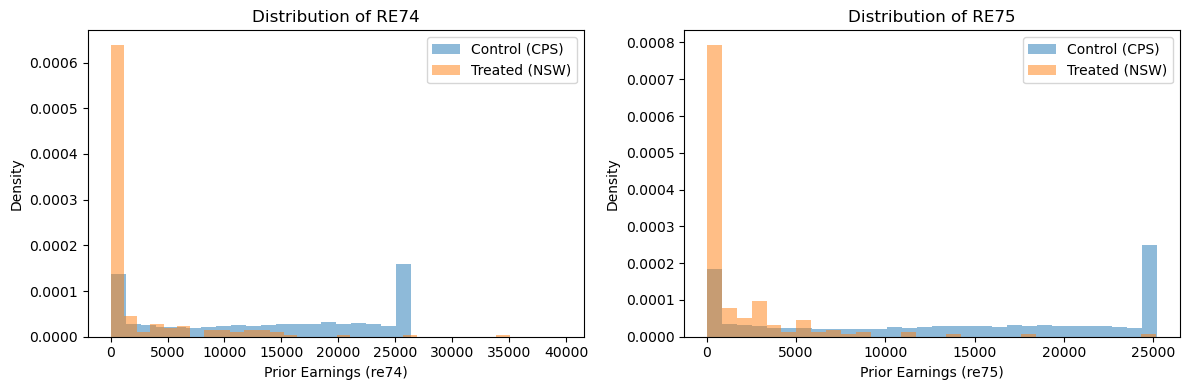

Note: NSW participants had much lower prior earnings than CPS controls!


In [11]:
# Visualize prior earnings distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, var in enumerate(["re74", "re75"]):
    ax = axes[i]
    ax.hist(
        combined[combined["treat"] == 0][var],
        bins=30,
        alpha=0.5,
        label="Control (CPS)",
        density=True,
    )
    ax.hist(
        combined[combined["treat"] == 1][var],
        bins=30,
        alpha=0.5,
        label="Treated (NSW)",
        density=True,
    )
    ax.set_xlabel(f"Prior Earnings ({var})")
    ax.set_ylabel("Density")
    ax.legend()
    ax.set_title(f"Distribution of {var.upper()}")

plt.tight_layout()
plt.show()

print("Note: NSW participants had much lower prior earnings than CPS controls!")


### CausalPy Inverse Propensity Weighting

Now we'll use CausalPy to estimate propensity scores and compute the IPW-adjusted treatment effect.

CausalPy's `InversePropensityWeighting` supports several weighting schemes:
- **raw**: Simple inverse probability weighting
- **robust**: Horvitz-Thompson type weighting
- **doubly robust**: Combines propensity and outcome models
- **overlap**: Targets the overlap population


In [12]:
# Prepare data for CausalPy
ipw_data = combined.copy()

# Ensure treat is 0/1 integer
ipw_data["treat"] = ipw_data["treat"].astype(int)

# Standardize continuous variables to help MCMC sampling
# Earnings are on very different scales (0 to ~40,000) which can cause divergences
ipw_data["age_std"] = (ipw_data["age"] - ipw_data["age"].mean()) / ipw_data["age"].std()
ipw_data["educ_std"] = (ipw_data["educ"] - ipw_data["educ"].mean()) / ipw_data[
    "educ"
].std()
ipw_data["re74_std"] = (ipw_data["re74"] - ipw_data["re74"].mean()) / ipw_data[
    "re74"
].std()
ipw_data["re75_std"] = (ipw_data["re75"] - ipw_data["re75"].mean()) / ipw_data[
    "re75"
].std()

# Check for missing values in key columns
key_cols = [
    "treat",
    "age",
    "educ",
    "black",
    "hisp",
    "marr",
    "nodegree",
    "re74",
    "re75",
    "u74",
    "u75",
    "re78",
]
print(f"Missing values:\n{ipw_data[key_cols].isnull().sum()}")
print(f"\nDataset shape: {ipw_data.shape}")
print(f"\nStandardized variable ranges:")
print(f"  age_std:  [{ipw_data['age_std'].min():.2f}, {ipw_data['age_std'].max():.2f}]")
print(
    f"  educ_std: [{ipw_data['educ_std'].min():.2f}, {ipw_data['educ_std'].max():.2f}]"
)
print(
    f"  re74_std: [{ipw_data['re74_std'].min():.2f}, {ipw_data['re74_std'].max():.2f}]"
)
print(
    f"  re75_std: [{ipw_data['re75_std'].min():.2f}, {ipw_data['re75_std'].max():.2f}]"
)


Missing values:
treat       0
age         0
educ        0
black       0
hisp        0
marr        0
nodegree    0
re74        0
re75        0
u74         0
u75         0
re78        0
dtype: int64

Dataset shape: (16437, 17)

Standardized variable ranges:
  age_std:  [-1.54, 1.99]
  educ_std: [-4.18, 2.10]
  re74_std: [-1.42, 2.67]
  re75_std: [-1.42, 1.27]


In [13]:
# Run CausalPy IPW with robust weighting
sample_kwargs = {
    "tune": 1000,
    "draws": 500,
    "chains": 4,
    "cores": 4,
    "target_accept": 0.99,  # Higher target_accept for this challenging problem
    "progressbar": True,
}

# Propensity score formula using STANDARDIZED continuous variables
# This helps MCMC sampling converge better (avoids divergences from large scale differences)
ipw_result = cp.InversePropensityWeighting(
    ipw_data,
    formula="treat ~ 1 + age_std + educ_std + black + hisp + marr + nodegree + re74_std + re75_std + u74 + u75",
    outcome_variable="re78",
    weighting_scheme="robust",
    model=cp.pymc_models.PropensityScore(sample_kwargs=sample_kwargs),
)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]


Output()

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 40 seconds.
Sampling: [b, t_pred]
Sampling: [t_pred]


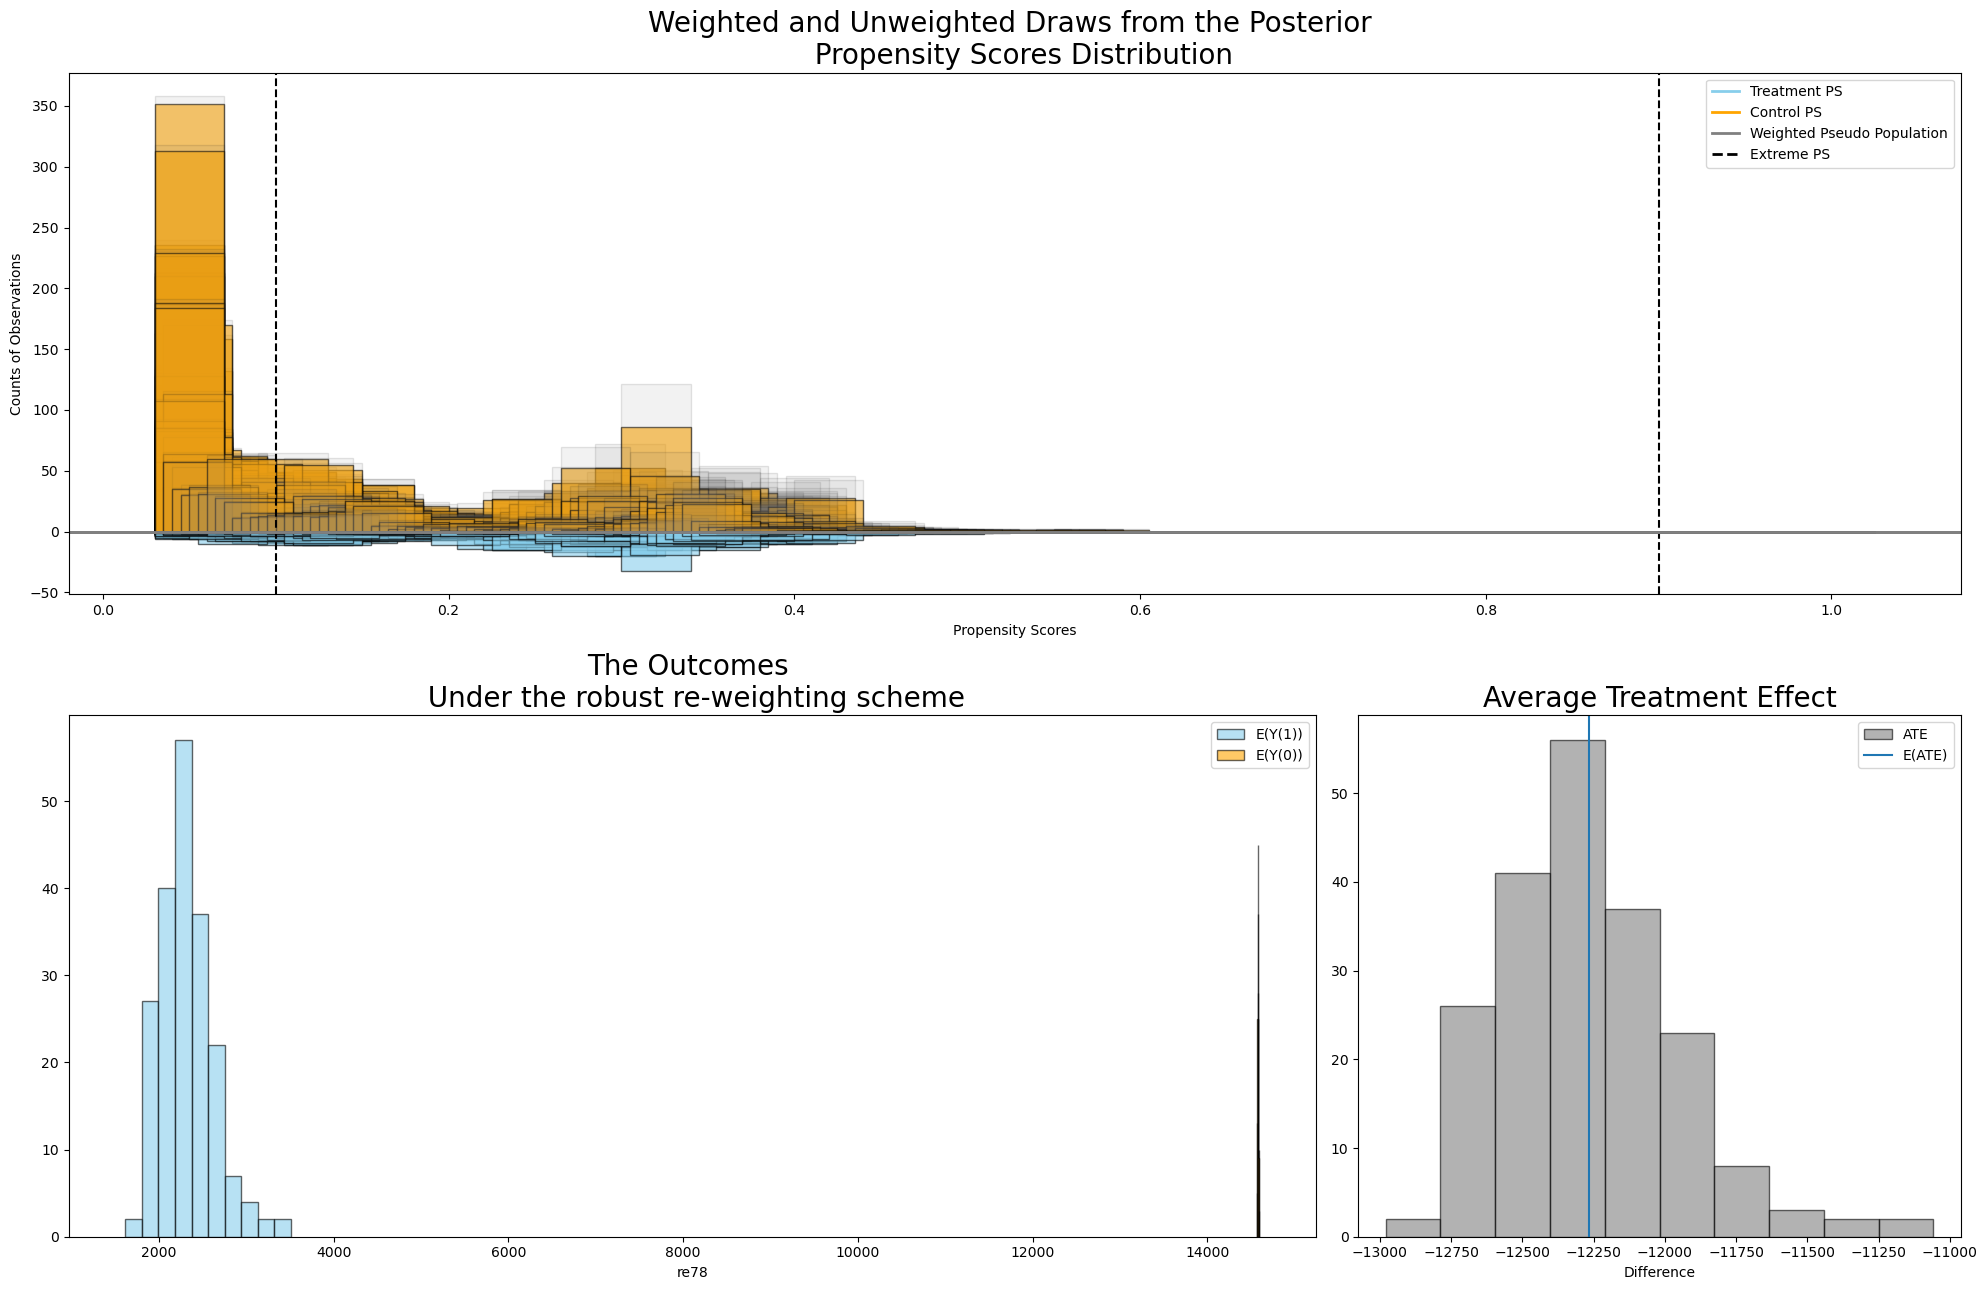

In [14]:
# Plot the results - propensity score distribution and ATE
fig, axs = ipw_result.plot_ate(prop_draws=50, ate_draws=200)
plt.tight_layout()
plt.show()


In [15]:
# Extract ATE estimates
ate_samples = [
    ipw_result.get_ate(i, ipw_result.model.idata, method="robust")[0]
    for i in range(200)
]
ate_mean = np.mean(ate_samples)
ate_std = np.std(ate_samples)

print("IPW Results (Robust Weighting):")
print(f"  Estimated ATE: ${ate_mean:,.2f}")
print(f"  Std Dev: ${ate_std:,.2f}")
print(
    f"  95% CI: [${ate_mean - 1.96 * ate_std:,.2f}, ${ate_mean + 1.96 * ate_std:,.2f}]"
)
print(f"\nExperimental benchmark: ${experimental_ate:,.2f}")


IPW Results (Robust Weighting):
  Estimated ATE: $-12,264.54
  Std Dev: $307.47
  95% CI: [$-12,867.18, $-11,661.90]

Experimental benchmark: $1,794.34


### Balance Diagnostics

CausalPy provides tools to check whether the weighting achieves covariate balance:


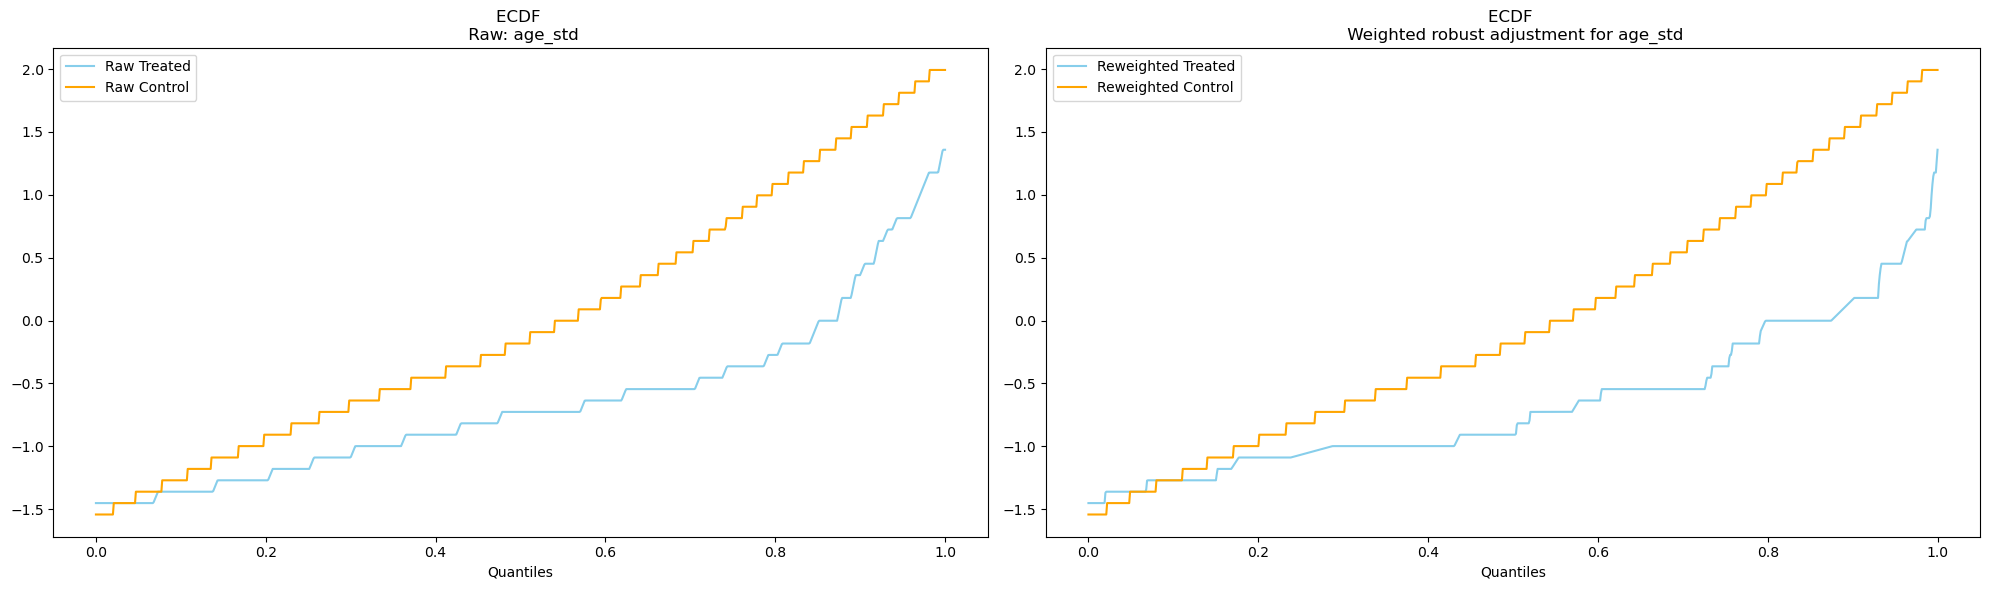

In [16]:
# Check balance for age covariate (using standardized variable)
fig, axs = ipw_result.plot_balance_ecdf("age_std")
plt.tight_layout()
plt.show()


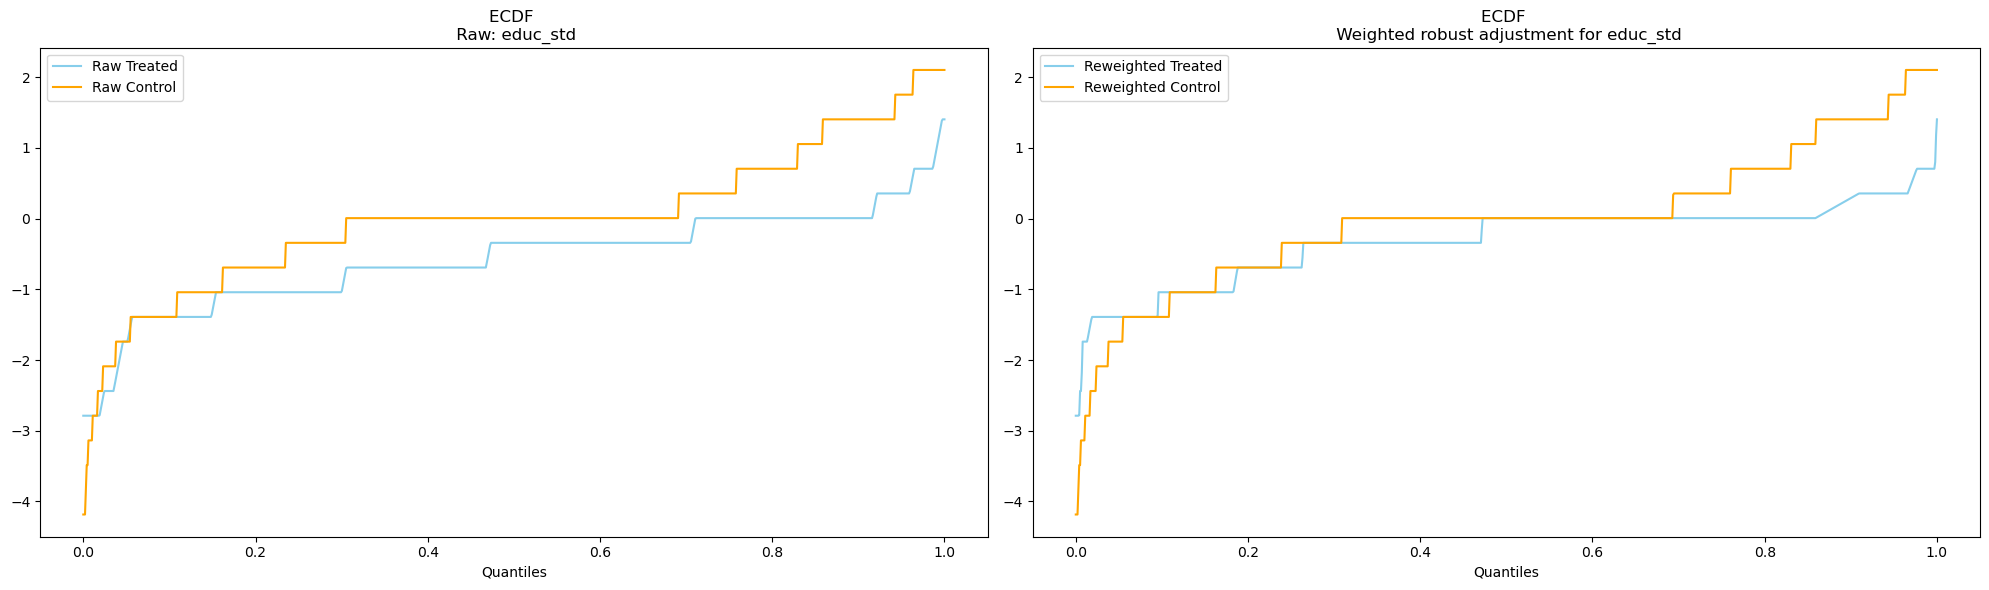

In [17]:
# Check balance for education (using standardized variable)
fig, axs = ipw_result.plot_balance_ecdf("educ_std")
plt.tight_layout()
plt.show()


---

## Comparison to Mixtape Results

### Key Differences

| Aspect | Mixtape | This Notebook |
|--------|---------|---------------|
| Propensity model | Logistic regression (statsmodels) | Bayesian logistic (PyMC) |
| Weighting | Manual Horvitz-Thompson | CausalPy `robust` scheme |
| Uncertainty | Bootstrap or asymptotic | Bayesian posterior |
| Specification | Polynomial terms + interactions | Linear in covariates |

### The LaLonde Problem

The famous LaLonde (1986) paper showed that observational estimators often fail to recover the experimental benchmark. The NSW treated group was very different from CPS controls:

- **Lower prior earnings**: NSW participants were disadvantaged workers
- **Different demographics**: More minority, less educated
- **Selection into treatment**: Voluntary program participation

IPW attempts to correct for these differences by reweighting, but:
- Limited overlap can cause extreme weights
- Model misspecification affects results
- No adjustment for unobservables


---

## TODO: Subclassification

> **Not yet implemented**: Subclassification stratifies observations into propensity score bins and estimates effects within each stratum.

**Mixtape reference**: `titanic_subclassification.py`

**CausalPy tracking**: No current issue/PR for subclassification

**When to revisit**: Would need a new method in CausalPy.


---

## TODO: Nearest Neighbor Matching

> **Not yet implemented**: Nearest neighbor matching pairs treated units with similar control units based on propensity scores or covariates.

**Mixtape reference**: `teffects_nn.py` (file is empty in original repo)

**CausalPy tracking**: No current issue/PR for matching

**When to revisit**: Would need a new `cp.Matching` experiment class.


---

## TODO: Coarsened Exact Matching (CEM)

> **Not yet implemented**: CEM temporarily coarsens covariates and performs exact matching within coarsened strata.

**Mixtape reference**: `cem.py` (file is empty in original repo)

**CausalPy tracking**: No current issue/PR for CEM

**When to revisit**: Would need a new experiment class in CausalPy.


---

## Summary

In this notebook, we demonstrated:

1. **Simple Difference in Outcomes**: The Titanic example shows that naive comparisons can be misleading when treatment is not randomly assigned.

2. **Experimental Benchmark**: The NSW randomized experiment provides an unbiased ATE estimate (~$1,794) that serves as our ground truth.

3. **The LaLonde Problem**: When we substitute CPS controls for the experimental controls, the naive difference is heavily biased (negative!).

4. **CausalPy IPW**: Using `InversePropensityWeighting`, we attempted to recover the experimental benchmark by reweighting observations based on their probability of treatment.

**Key takeaways:**

- IPW is one approach to addressing selection bias in observational studies
- CausalPy provides Bayesian propensity score estimation with uncertainty quantification
- Balance diagnostics help assess whether weighting achieves covariate balance
- The LaLonde problem remains challenging — observational methods may not fully recover experimental estimates

**What CausalPy supports:**
- ✅ Inverse Propensity Weighting (multiple schemes)
- ✅ Propensity score diagnostics
- ✅ Balance plots

**What's not yet available:**
- ❌ Nearest neighbor matching
- ❌ Subclassification
- ❌ Coarsened exact matching


---

## References

- **Mixtape chapter**: https://mixtape.scunning.com/05-matching_and_subclassification
- **CausalPy docs**: https://causalpy.readthedocs.io
- **Original papers**:
  - LaLonde, R. (1986). "Evaluating the Econometric Evaluations of Training Programs with Experimental Data"
  - Dehejia, R. & Wahba, S. (1999). "Causal Effects in Nonexperimental Studies: Reevaluating the Evaluation of Training Programs"
  - Rosenbaum, P. & Rubin, D. (1983). "The Central Role of the Propensity Score in Observational Studies for Causal Effects"
- **Weighting schemes**:
  - Aronow, P. & Miller, B. (2019). "Foundations of Agnostic Statistics"
